In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
import glob
import os
import tarfile
from correlation_helpers import *


## Correlation Visualisation

# Correlation Matrix

This notebook will be dedicated to the correlation matrix generation and cleaning. 
Will proceed in two steps:
* Test out correlation mx generation and cleaning on the hourly log returns
* Reduce granularity and build a general pipelne for different time windows

In [31]:
returns=reconstruct_returns("log returns",min_row_requirement=100)

Total return matrix has dimensions (86, 143)


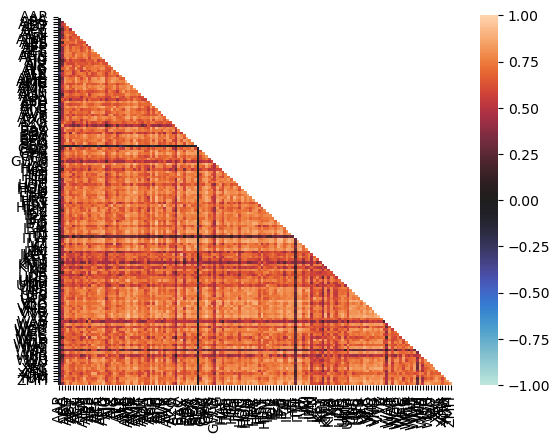

In [32]:
correlation_mx=np.corrcoef(returns,rowvar=False)
sns.heatmap(correlation_mx,
            xticklabels=returns.columns[1:],
            yticklabels=returns.columns[1:],
            mask=np.triu(correlation_mx),
            vmin=-1,
            vmax=1,
            center= 0)
plt.show()

## Eigen Value Clipping

In [33]:
from numpy import linalg as LA
import numpy as np
import pandas as pd
import math

def eigenvalue_clipping(lambdas,v,lambda_plus):
    N=len(lambdas)
    
    
    # _s stands for _structure below
    sum_lambdas_gt_lambda_plus=np.sum(lambdas[lambdas>lambda_plus])
    
    sel_bulk=lambdas<=lambda_plus                     # these eigenvalues come from the seemingly random bulk
    N_bulk=np.sum(sel_bulk)
    sum_lambda_bulk=np.sum(lambdas[sel_bulk])        
    delta=sum_lambda_bulk/N_bulk                      # delta is their average, so as to conserver the trace of C
    
    lambdas_clean=lambdas
    lambdas_clean[lambdas_clean<=lambda_plus]=delta
    
    
    C_clean=np.zeros((N, N))
    v_m=np.matrix(v)
    
    for i in range(N-1):
        C_clean=C_clean+lambdas_clean[i] * np.dot(v_m[i,].T,v_m[i,]) 
        
    np.fill_diagonal(C_clean,1)
            
    return C_clean   

In [34]:
lambdas_e, V_e=LA.eig(correlation_mx)

### Marcenko-Pastur distribution

In [41]:
def P0(lambdas,q):
    lambda_plus = (1+np.sqrt(q))**2
    lambda_minus = (1-np.sqrt(q))**2
    vals = 1/(q*2*np.pi*lambdas)*np.sqrt((lambda_plus-lambdas)*(lambdas-lambda_minus))
    return vals

In [36]:
q=returns.shape[0]/returns.shape[1]
lambdas=np.linspace((1.-np.sqrt(q))**2,(1.+np.sqrt(q))**2,200)
P0s=P0(lambdas,q)

c:\Users\Kamal\miniconda3\envs\Fin_Big_Data\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Kamal\miniconda3\envs\Fin_Big_Data\Lib\site-packages\pandas\core\dtypes\astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


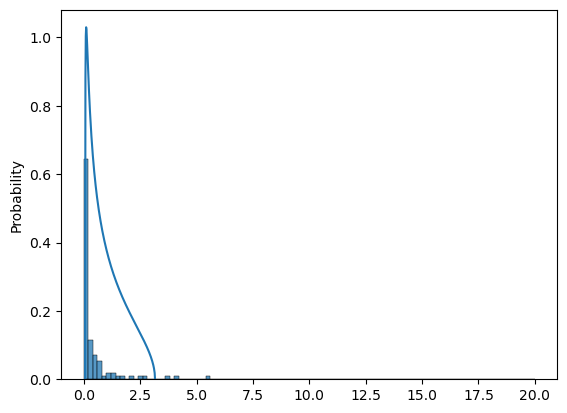

In [37]:
sns.histplot(lambdas_e, kde=False, stat="probability", bins=100, binrange=(0, 20))
plt.plot(lambdas,P0s)

In [38]:
lambda_plus=(1+np.sqrt(q))**2
C_clipped=eigenvalue_clipping(lambdas_e,V_e,lambda_plus)
C_clipped # it works

matrix([[ 1.        +0.00000000e+00j, -0.15049665-3.18489705e-35j,
         -0.02610543+8.38469218e-35j, ..., -0.04713369+9.10327823e-35j,
         -0.0633861 +1.75760947e-02j, -0.0633861 -1.75760947e-02j],
        [-0.15049665-3.18489705e-35j,  1.        +0.00000000e+00j,
          0.31902788+2.49117910e-35j, ...,  0.27603073+8.19374217e-35j,
          0.15579204-7.33234779e-02j,  0.15579204+7.33234779e-02j],
        [-0.02610543+8.38469218e-35j,  0.31902788+2.49117910e-35j,
          1.        +0.00000000e+00j, ...,  0.08435024+1.66542353e-34j,
          0.01279159-2.41348543e-02j,  0.01279159+2.41348543e-02j],
        ...,
        [-0.04713369+9.10327823e-35j,  0.27603073+8.19374217e-35j,
          0.08435024+1.66542353e-34j, ...,  1.        +0.00000000e+00j,
         -0.00868554+2.89126916e-03j, -0.00868554-2.89126916e-03j],
        [-0.0633861 +1.75760947e-02j,  0.15579204-7.33234779e-02j,
          0.01279159-2.41348543e-02j, ..., -0.00868554+2.89126916e-03j,
          1.        

## Clipping Sanity Check

This part ensures that the cleaning was done properly in order to troubleshoot deficiencies.

In [39]:
# Test symmetry
assert np.allclose(C_clipped, C_clipped.T, atol=1e-8) , "The clipped Matrix is not symmetric"

# Check diagonal elements
assert np.allclose(np.diag(C_clipped), 1), "The diagonal elements are not 1."

# Check positive semi-definiteness
eigenvalues_clean = np.linalg.eigvalsh(C_clipped)
assert np.all(eigenvalues_clean >= 0), "The cleaned matrix is not positive semi-definite."

AssertionError: The cleaned matrix is not positive semi-definite.

### Comparing the original and clipped eigenvalues

c:\Users\Kamal\miniconda3\envs\Fin_Big_Data\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Kamal\miniconda3\envs\Fin_Big_Data\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


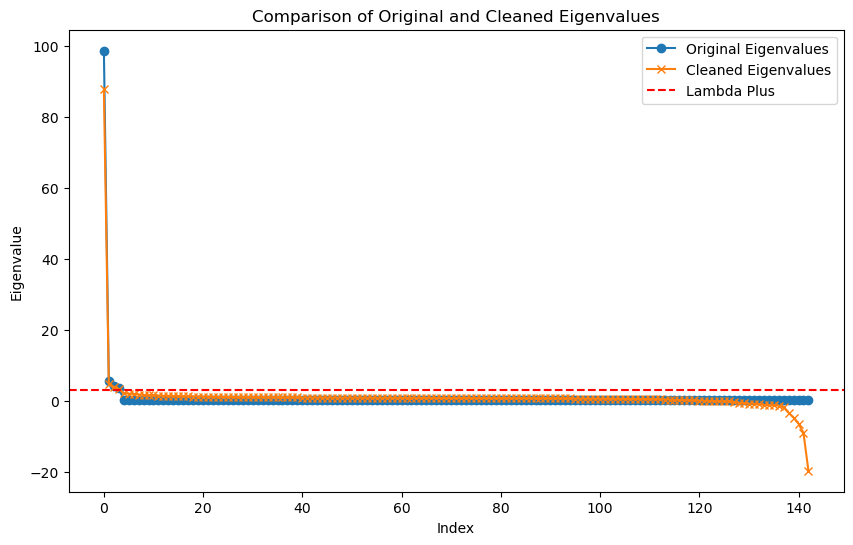

In [51]:
import matplotlib.pyplot as plt

# Plot original and cleaned eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(np.sort(lambdas_e)[::-1], label="Original Eigenvalues", marker='o')
plt.plot(np.sort(eigenvalues_clean)[::-1], label="Cleaned Eigenvalues", marker='x')
plt.axhline(lambda_plus, color='red', linestyle='--', label="Lambda Plus")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.title("Comparison of Original and Cleaned Eigenvalues")
plt.show()

#### Trace preservation check

In [59]:
original_trace = np.sum(lambdas_e)
cleaned_trace = np.sum(eigenvalues_clean)

np.isclose(original_trace, cleaned_trace)

True

#### Comparison with Marcenko-Pastur

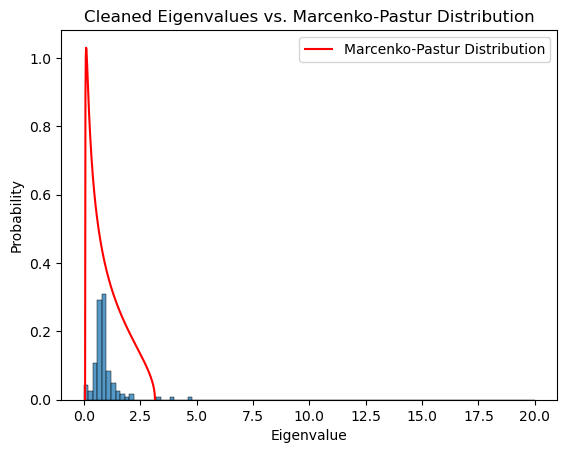

In [62]:
# Plot histogram of cleaned eigenvalues
sns.histplot(eigenvalues_clean, kde=False, stat="probability", bins=100, binrange=(0, 20))
plt.plot(lambdas, P0(lambdas, q), label="Marcenko-Pastur Distribution", color='red')
plt.xlabel("Eigenvalue")
plt.ylabel("Probability")
plt.title("Cleaned Eigenvalues vs. Marcenko-Pastur Distribution")
plt.legend()
plt.show()

***GPT INTERPRETATION ***

## Bulk Conformity (Noise):

The cleaned eigenvalues in the histogram closely follow the MP distribution, especially in the region near 0 to lambda_plus.
This indicates that the bulk of the eigenvalues corresponds to random noise and was cleaned effectively.
Deviations from MP Distribution (Signal):

Eigenvalues that significantly deviate from the MP distribution (e.g., larger eigenvalues) represent meaningful signals in the data.
In this graph, there seem to be very few deviations, suggesting most eigenvalues fall into the random noise category. If there are no clear outliers, it might imply a lack of strong structure or signals in the data.
Support Boundaries (Lambda Plus):

The MP distribution theoretically has a support boundary defined by lambda_minus and lambda_plus.
Ensure the red curve accurately reflects these boundaries to confirm the cleaning was performed correctly.

## What This Tells You
Effectiveness of Cleaning:

The bulk eigenvalues conforming to the MP distribution indicate that the eigenvalue clipping successfully removed noise while preserving the trace of the matrix.
Presence of Signal:

If there are no eigenvalues significantly above lambda_plus, it suggests that there are no dominant signals or structures in the data.
If signals exist, the cleaned eigenvalues should have a few outliers well above the MP distribution's range.

##

## Correlating timestamps.

In [14]:
returns.sample(2)

index,AAP,AA,ABC,ABD,ABT,ACE,ACL,ACN,ADI,ADM,ADS,AEE,AEP,AES,AFL,AGN,AHC,AIG,AIV,AIZ,AJG,ALB,ALK,ALL,AMB,AMD,AME,AMP,AMR,AMT,AON,AOS,APA,APD,APH,ARE,…,UNP,UPS,URI,USB,UTX,VAR,VFC,VLO,VMC,VNO,VTR,VZ,V,WAB,WAG,WAT,WCG,WDC,WEC,WFC,WHR,WLP,WMB,WMT,WM,WPI,WRB,WR,WSH,WU,WY,XEC,XEL,XOM,XRX,YUM,ZMH
"datetime[μs, America/New_York]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-05-14 11:00:00 EDT,0.000008,0.000001,0.000003,0.000032,3.3657e-7,8.7736e-7,9.3430e-7,0.000005,0.000006,0.000001,0.000007,0.000001,4.9369e-7,-2.8643e-7,0.000001,0.000004,-0.000176,5.8467e-7,0.00001,0.000004,-0.000004,0.000017,0.000062,0.000002,0.000009,0.000002,0.000007,0.000008,0.000011,0.000002,0.000002,0.000112,0.000002,0.000008,0.000012,0.000004,…,0.000004,0.000003,0.000017,0.000001,0.000001,0.00001,0.000007,0.000004,0.000003,0.000003,0.000007,3.1562e-7,0.000002,0.000067,0.000001,0.00001,0.00004,0.000007,0.000004,4.0552e-7,0.000021,9.8639e-7,0.000002,9.8043e-8,0.000004,0.000006,0.000004,0.000002,0.000016,0.000003,0.000007,0.000005,0.000001,4.9907e-7,0.000007,0.000004,0.000008
2010-05-05 11:00:00 EDT,-0.000008,-0.000002,-0.000002,-0.000087,-1.3511e-7,-0.000002,3.3866e-8,0.000001,-0.000001,-0.000002,-0.000003,3.3581e-8,0.000002,-0.000007,-0.000003,-0.000001,0.000113,-6.2681e-7,-0.000011,-0.000004,-7.8962e-7,-0.000004,0.000004,-0.000003,-0.000009,0.000001,0.000002,-0.000006,0.000004,1.7336e-7,-0.000002,-0.000004,-0.000003,-0.000001,-0.000015,-0.000012,…,-0.000003,4.3712e-7,-0.000003,7.6811e-7,-0.000001,-0.000001,-0.00001,-0.000006,-0.000008,-0.000009,-0.000006,6.5650e-7,-0.000002,-6.7826e-7,-0.000003,-0.000006,0.000004,-0.000003,0.000005,-7.4788e-7,-0.000004,-0.000003,-5.7951e-7,-8.7298e-7,-1.5344e-18,0.000009,0.000002,-0.000001,-0.000007,-0.000003,-0.000014,-0.00001,0.000003,-7.0154e-7,-0.000003,-0.000005,-0.000002


timestamp_coefs=np.corrcoef(returns.drop('index'),rowvar=True)
sns.heatmap(timestamp_coefs,
            mask=np.triu(timestamp_coefs),
            vmin=-1,
            vmax=1,
            center= 0)
plt.show()

In [65]:
def plot_corr_heatmap(corr,df,on_timestamp,ax):
        if on_timestamp:
            sns.heatmap(corr, ax=ax,
            mask=np.triu(corr),
            vmin=-1,
            vmax=1,
            center= 0)
        else:

            sns.heatmap(corr, ax=ax,
            xticklabels=df.columns[1:],
            yticklabels=df.columns[1:],
            mask=np.triu(corr),
            vmin=-1,
            vmax=1,
            center= 0)
        ax.set_title('Correlation Heatmap')

def plot_MP_dist(lambdas_emp,lambdas_mp,p0s,ax):
        sns.histplot(lambdas_emp, kde=False, stat="probability", bins=100, binrange=(0, 20),ax=ax)
        ax.plot(lambdas_mp,p0s)
        ax.set_title(' Expected Marcenko-Pastur EV distribution vs Observed Distribution ')

def ev_cleaning_plotting(lambdas_emp,clean_ev,lambda_plus,ax):
        ax.plot(np.sort(lambdas_emp)[::-1], label="Original Eigenvalues", marker='o')
        ax.plot(np.sort(clean_ev)[::-1], label="Cleaned Eigenvalues", marker='x')
        ax.axhline(lambda_plus, color='red', linestyle='--', label="Lambda Plus")
        ax.set_xlabel("Index")
        ax.set_ylabel("Eigenvalue")
        ax.legend()
        ax.set_title("Comparison of Original and Cleaned Eigenvalues")

def plot_MP_clean(clean_ev,lambdas_mp,p0s,ax):
        sns.histplot(clean_ev, kde=False, stat="probability", bins=100, binrange=(0, 20),ax=ax)
        ax.plot(lambdas_mp, p0s, label="Marcenko-Pastur Distribution", color='red')
        ax.set_xlabel("Eigenvalue")
        ax.set_ylabel("Probability")
        ax.set_title("Cleaned Eigenvalues vs. Marcenko-Pastur Distribution")
        ax.legend()


In [66]:
np.corrcoef(returns.drop('index'),rowvar=True)

array([[ 1.        , -0.21674684, -0.86504391, ..., -0.04924465,
        -0.1810101 ,  0.68768254],
       [-0.21674684,  1.        , -0.14838184, ...,  0.97621933,
         0.99658372,  0.48062563],
       [-0.86504391, -0.14838184,  1.        , ..., -0.31279297,
        -0.19427062, -0.88749187],
       ...,
       [-0.04924465,  0.97621933, -0.31279297, ...,  1.        ,
         0.98582831,  0.63064594],
       [-0.1810101 ,  0.99658372, -0.19427062, ...,  0.98582831,
         1.        ,  0.52463666],
       [ 0.68768254,  0.48062563, -0.88749187, ...,  0.63064594,
         0.52463666,  1.        ]])

In [69]:
def ev_cleaning(returns,on_timestamp=False):
        fig,axs=plt.subplots(4,1,figsize=(6,20))
        if on_timestamp:
                corr_mx=np.corrcoef(returns.drop('index'),rowvar=on_timestamp)
        else:
                corr_mx=np.corrcoef(returns,rowvar=on_timestamp)
   
        
        #plot original correlation heatmap.
        plot_corr_heatmap(corr_mx,returns,on_timestamp,axs[0])

        lambdas_empirical, V_emprirical=LA.eig(correlation_mx)
        q=returns.shape[0]/returns.shape[1]
        lambdas=np.linspace((1.-np.sqrt(q))**2,(1.+np.sqrt(q))**2,200)
        P0s=P0(lambdas,q)

        #plot theoritical ev distribution again empirical distribution
        plot_MP_dist(lambdas_empirical,lambdas,P0s,axs[1])

        lambda_plus=(1+np.sqrt(q))**2
        C_clipped=eigenvalue_clipping(lambdas_empirical,V_emprirical,lambda_plus)
        C_clipped # it works

        #Eigenvalues after cleaning.
        eigenvalues_clean = np.linalg.eigvalsh(C_clipped)

        # Plot original and cleaned eigenvalues
        ev_cleaning_plotting(lambdas_empirical,eigenvalues_clean,lambda_plus=lambda_plus,ax=axs[2])

        # Plot histogram of cleaned eigenvalues
        plot_MP_clean(eigenvalues_clean,lambdas,P0s,axs[3])
        return C_clipped


    

ON TIMESTAMP


c:\Users\Kamal\miniconda3\envs\Fin_Big_Data\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Kamal\miniconda3\envs\Fin_Big_Data\Lib\site-packages\pandas\core\dtypes\astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
c:\Users\Kamal\miniconda3\envs\Fin_Big_Data\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Kamal\miniconda3\envs\Fin_Big_Data\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


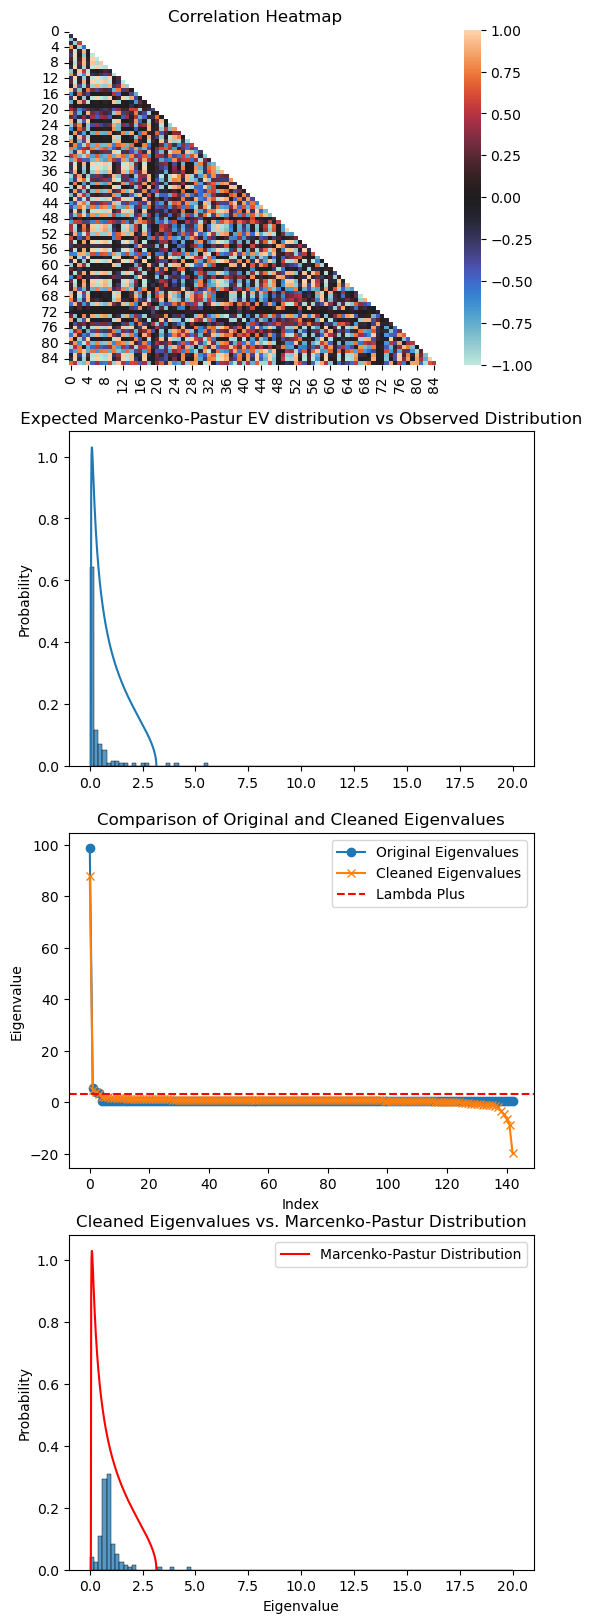

In [71]:
correlation_timestamp=ev_cleaning(returns,on_timestamp=True)